In [2]:
!pip install pulp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 44.7 MB/s eta 0:00:00


In [31]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from pandas import Timestamp
from pulp import *

In [4]:
from google.colab import files
upload = files.upload()

Saving 5.txt to 5.txt
Saving 7.txt to 7.txt
Saving 10_pocos.txt to 10_pocos.txt
Saving 10_todos.txt to 10_todos.txt
Saving 10_varios.txt to 10_varios.txt
Saving 15.txt to 15.txt
Saving 20.txt to 20.txt
Saving 50.txt to 50.txt
Saving 75.txt to 75.txt
Saving 100.txt to 100.txt
Saving 200.txt to 200.txt
Saving FormatoArchivos.txt to FormatoArchivos.txt
Saving Resultados Esperados.txt to Resultados Esperados.txt


### Read File

In [5]:
def read_file(path):
    jugadores = []
    with open(path, 'r') as file:
        for linea in file:
            jug_x_periodista = linea.strip().split(',')

            jugadores.append(jug_x_periodista)

    return jugadores

# Algoritmos

## Greedy

In [6]:
def greedy_jugadores(jugadores_matrix):
    jugadores = jugadores_matrix.copy()
    jugadores.sort(key=lambda x: len(x))

    solucion = set()

    for propuestas in jugadores:
        optimo_local = propuestas[0] # primer jugador que no está en el set
        for jugador in propuestas:
            if jugador in solucion:
                optimo_local = jugador
                break
        solucion.add(optimo_local)

    return solucion

## Backtracking

In [13]:
def _backtracking_jugadores(jugadores_matriz, periodista, solucion_optima, solucion_actual):
    if periodista == len(jugadores_matriz):
        if len(solucion_optima) == 0 or len(solucion_actual) <= len(solucion_optima):
            solucion_optima = solucion_actual.copy()
        return solucion_optima

    if len(solucion_optima) != 0 and len(solucion_actual) >= len(solucion_optima):
        return solucion_optima

    for jugador in jugadores_matriz[periodista]:
        jugadores_temporales = solucion_actual.copy()
        jugadores_temporales.add(jugador)

        solucion_optima = _backtracking_jugadores(jugadores_matriz, periodista + 1, solucion_optima, jugadores_temporales)

    return solucion_optima

def backtracking_jugadores(jugadores):
  return _backtracking_jugadores(jugadores, 0, set(), set())

## Programación Lineal

In [32]:
def programacion_lineal_jugadores(jugadores):
    jugadores_segun_preferencias = jugadores
    todos_los_jugadores = set()
    for preferencia in jugadores_segun_preferencias:
        for jugador in preferencia:
            todos_los_jugadores.add(jugador)

    problema = LpProblem("jugadores_optimos", LpMinimize)
    jugadores_vars = {jugador: LpVariable(f"x_{jugador}", 0, 1, LpBinary) for jugador in todos_los_jugadores}
    problema += lpSum(jugadores_vars[jugador] for jugador in todos_los_jugadores)
    for preferencia in jugadores_segun_preferencias:
        problema += lpSum(jugadores_vars[jugador] * (jugador in preferencia) for jugador in todos_los_jugadores) >= 1
    problema.solve()

# Generación de sets

In [10]:
rng = np.random.default_rng(seed=42)
def generate_random(n, min_players=2, max_players=8, lower_limit=1, upper_limit=50):
  return [rng.integers(lower_limit, upper_limit, size=rng.integers(2, max_players)) for _ in range(n)]

In [11]:
generate_random(10)

[array([38, 33]),
 array([22, 43,  5, 35]),
 array([ 5, 26, 48]),
 array([38, 36, 39, 26,  7, 42]),
 array([25, 19,  9, 46]),
 array([32, 20, 41, 27, 22, 23]),
 array([ 5, 28, 44]),
 array([43, 41]),
 array([31,  9, 38]),
 array([18,  4, 48, 22, 44, 34])]

## Pruebas de tiempos

In [34]:
import time

In [35]:
def timeit_scaloni(algoritmo, jugadores):
  start_time = time.time()
  _ = algoritmo(jugadores)
  end_time = time.time()
  return end_time - start_time

In [62]:
 def get_plot_times(algoritmo, inicio_rango=5, fin_rango=500, incremento=25, modifier=1000):
  data_n = []
  data_time = []

  # reinicio el generator para obtener los mismos valores en cada corrida por algoritmo
  rng = np.random.default_rng(seed=42)
  def generate_random(n, min_players=2, max_players=8, lower_limit=1, upper_limit=50):
    return [rng.integers(lower_limit, upper_limit, size=rng.integers(2, max_players)) for _ in range(n)]

  for n in range(inicio_rango, fin_rango + 1, incremento):
    # Genera tus datos o carga datos de alguna fuente
    jugadores = generate_random(n)  # Ajusta esto según tu caso

    timeit = timeit_scaloni(algoritmo, jugadores)

    data_n.append(n)
    data_time.append(timeit * modifier)

  return data_n, data_time

In [65]:
def plot_scaloni(data_n, data_time, algoritmo_str):
  window_size = 5

  x = data_n
  y = data_time # [x/1000 for x in data_time]

  # y_suavizado = np.convolve(y, np.ones(window_size)/window_size, mode='same')

  plt.plot(x, y, label=f'Mediciones {algoritmo_str}', linewidth=2)
  # plt.plot(x, y_suavizado, label='Mediciones suavizadas', linewidth=2)
  # plt.plot(x, [n*n/60 for n in x], label='n2', linewidth=3)
  plt.title(f'Mediciones {algoritmo_str}')
  plt.xlabel('Tamaño de datos')
  plt.ylabel('Tiempo de ejecución [ms]')
  plt.grid(True)
  # plt.legend()
  plt.show()

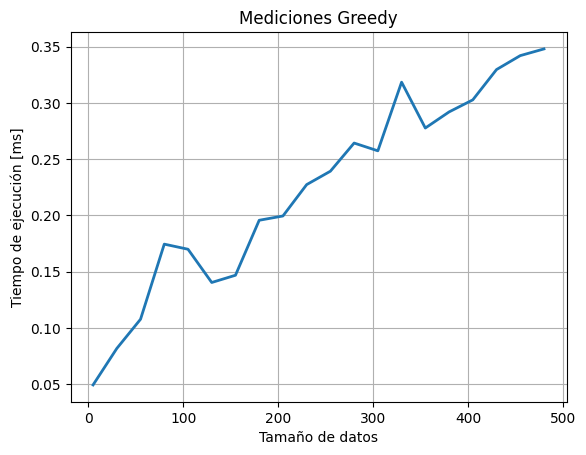

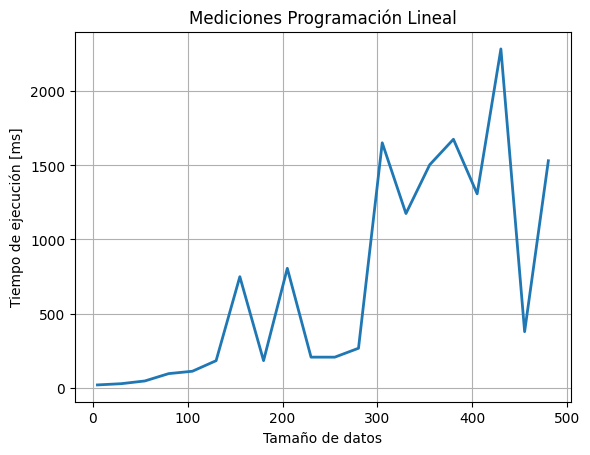

In [66]:
#ALL_ALGORITHMS = [greedy_jugadores, backtracking_jugadores, programacion_lineal_jugadores]
ALL_ALGORITHMS = []
ALL_ALGORITHMS.append((greedy_jugadores, 'Greedy'))
# ALL_ALGORITHMS.append((backtracking_jugadores, 'Backtracking'))
ALL_ALGORITHMS.append((programacion_lineal_jugadores, 'Programación Lineal'))

for algoritmo, name in ALL_ALGORITHMS:
  x, y = get_plot_times(algoritmo)
  plot_scaloni(x, y, name)